In [21]:
import numpy
import os
from struct import unpack
import matplotlib.pyplot as plt
import numpy as np
import colorsys
from matplotlib.widgets import Slider, Button, RadioButtons
from tkinter import *
from ipywidgets import widgets
from IPython.display import display
from IPython.html.widgets import *

In [2]:
def loadMtbFileStructure(fileName):
    f = open(fileName, "rb")
    try:
        fileNameLenghtBytes = f.read(4)  
        fileNameLenghtNode = unpack('i', fileNameLenghtBytes)
        fileNameLenght = sum(fileNameLenghtNode)
        fileName = loadFileNameStructure(f.read(fileNameLenght).decode("utf-8"))

        dateLenghtBytes = f.read(4)
        dateLenghtNode = unpack('i', dateLenghtBytes)
        dateLenght = sum(dateLenghtNode)
        date = f.read(dateLenght).decode("utf-8")
        
        notesLenghtBytes = f.read(4)
        notesLenghtNode = unpack('i', notesLenghtBytes)
        notesLenght = sum(notesLenghtNode)
        notes = f.read(notesLenght).decode("utf-8")
        f.read(16)
        
        dataPacketsLenghtBytes = f.read(4)
        dataPacketsLenghtNode = unpack('i', dataPacketsLenghtBytes)
        dataPacketsLenght = sum(dataPacketsLenghtNode)
        dataPackets = []
        for i in range(0, dataPacketsLenght):
            dataPacket = loadDataPacketStructure(f.read(24))
            dataPackets.append(dataPacket)
    finally:
        f.close()
    mtbFile = Mtb(fileName, date, notes, dataPackets)
    return mtbFile

def loadDataPacketStructure(dataPacketBytes):
    momentPomiaru = sum(unpack('i', dataPacketBytes[0:4]))
    polozenieX = sum(unpack('i', dataPacketBytes[4:8]))
    polozenieY = sum(unpack('i', dataPacketBytes[8:12]))
    nacisk = sum(unpack('i', dataPacketBytes[12:16]))
    szerokoscKatowa = sum(unpack('i', dataPacketBytes[16:20]))
    wysokoscKatowa = sum(unpack('i', dataPacketBytes[20:24]))
    return PakietDanych(momentPomiaru, polozenieX, polozenieY, nacisk, szerokoscKatowa, wysokoscKatowa)
    

def loadFileNameStructure(fileNameString):
    lp = fileNameString[:fileNameString.find('_', 0)]
    tmp = fileNameString.find('_', len(lp)+1)
    idPacjenta = fileNameString[len(lp)+1:tmp]
    nrOperacji = fileNameString[tmp+1]
    badanie = fileNameString[tmp+2]
    plec = fileNameString[tmp+3]
    reka = fileNameString[tmp+4]
    polkula = fileNameString[tmp+5]
    zabieg = fileNameString[tmp+6]
    return NazwaPliku(lp, idPacjenta, nrOperacji, badanie, plec, reka, polkula, zabieg)

In [3]:
class PakietDanych(object):
    momentPomiaru = 0.0
    polozenieX = 0.0
    polozenieY = 0.0
    nacisk = 0.0
    szerokoscKatowa = 0.0
    wysokoscKatowa = 0.0
    
    def __init__(self, momentPomiaru, polozenieX, polozenieY, nacisk, szerokoscKatowa, wysokoscKatowa):
        self.momentPomiaru = momentPomiaru
        self.polozenieX = polozenieX
        self.polozenieY = polozenieY
        self.nacisk = nacisk
        self.szerokoscKatowa = szerokoscKatowa
        self.wysokoscKatowa = wysokoscKatowa
        
class NazwaPliku(object):
    lp = -1
    idPacjenta = -1
    nrOperacji = -1
    badanie = -1
    plec = ''
    reka = ''
    polkula = ''
    zabieg = ''
    
    def __init__(self, lp, idPacjenta, nrOperacji, badanie, plec, reka, polkula, zabieg):
        self.lp = lp
        self.idPacjenta = idPacjenta
        self.nrOperacji = nrOperacji
        self.badanie = badanie
        self.plec = plec
        self.reka = reka
        self.polkula = polkula
        self.zabieg = zabieg
        
class Mtb(object):
    nazwaPliku = object
    data = ''
    notatki = ''
    pakietyDanych = []    
    def __init__(self, nazwaPliku, data, notatki, pakietyDanych):
        self.nazwaPliku = nazwaPliku
        self.data = data
        self.notatki = notatki
        self.pakietyDanych = pakietyDanych


In [4]:
def getAllMtbFilesFrom(folderName):
    mtbFiles = []
    for name in os.listdir(folderName):
        if name.endswith('.mtb'):
            mtbFile = loadMtbFileStructure(folderName + '/' + name)
            mtbFiles.append(mtbFile)
        elif os.path.isdir(folderName + '/' + name):
            mtbFiles += getAllMtbFilesFrom(folderName + '/' + name)
    return mtbFiles

In [5]:
def getColorForPlot(nacisk, minValue):
    #0 - wysoki nacisk
    #1/3 - niski nacisk
    #value przyjmuje wartosci 0-1023 (0 - niski nacisk, 1023 - wysoki nacisk)
    #Jeśli nacisk jest mniejszy niż minimalny dopuszczalny, to uznajemy, że nie rysował
    
    if minValue >= nacisk:
        return colorsys.hsv_to_rgb(0.0, 0.0, 0.0)
    nacisk /= 1024
    nacisk = 1 - nacisk
    nacisk /= 3
    return colorsys.hsv_to_rgb(nacisk, 1.0, 1.0)

In [57]:
mtbFiles = getAllMtbFilesFrom('./dane/33100000000 (M)')#/33100000000 (M)
print(mtbFiles)

[<__main__.Mtb object at 0x1307b5b70>, <__main__.Mtb object at 0x128bc62b0>, <__main__.Mtb object at 0x126017278>]


In [89]:
#X, Y, nacisk kolory, X(bez usuwania nacisku), Y(bez usuwania nacisku), nacisk kolory, grubosc kolory
plot = [[],[],[],[],[],[],[]]
minimalnyNacisk = 64
for i in range(0, len(mtbFiles)):
    plot[0].append([])
    plot[1].append([])
    plot[2].append([])
    plot[3].append([])
    plot[4].append([])
    plot[5].append([])
    plot[6].append([])
    for j in range(0, len(mtbFiles[i].pakietyDanych)):
        if mtbFiles[i].pakietyDanych[j].nacisk > minimalnyNacisk:
            plot[0][i].append(mtbFiles[i].pakietyDanych[j].polozenieX)
            plot[1][i].append(mtbFiles[i].pakietyDanych[j].polozenieY)
            plot[2][i].append(getColorForPlot(mtbFiles[i].pakietyDanych[j].nacisk, minimalnyNacisk))
            plot[6][i].append(1)
        else:
            plot[6][i].append(0.03)
        plot[3][i].append(mtbFiles[i].pakietyDanych[j].polozenieX)
        plot[4][i].append(mtbFiles[i].pakietyDanych[j].polozenieY)
        plot[5][i].append(getColorForPlot(mtbFiles[i].pakietyDanych[j].nacisk, minimalnyNacisk))

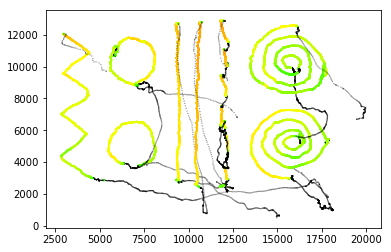

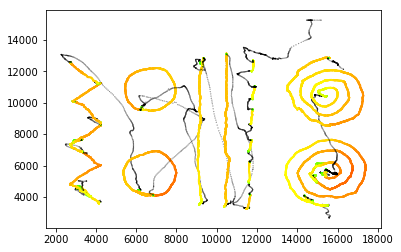

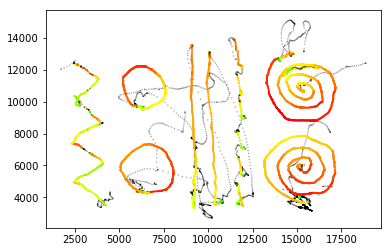

In [90]:
def plotConfiguration(Show_All_Lines, pokaz_nacisk):
    for i in range(0, len(mtbFiles)):
        if Show_All_Lines and pokaz_nacisk:
            plt.scatter(plot[3][i], plot[4][i], c=plot[5][i], s=plot[6][i])
        elif not Show_All_Lines and pokaz_nacisk:
            plt.scatter(plot[0][i], plot[1][i], c=plot[2][i], s=np.linspace(0.5, 0.5, num=len(plot[0][i])))
        elif Show_All_Lines and not pokaz_nacisk:
            plt.scatter(plot[3][i], plot[4][i], s=plot[6][i])
        elif not Show_All_Lines and not pokaz_nacisk: 
            plt.scatter(plot[0][i], plot[1][i], s=np.linspace(0.5, 0.5, num=len(plot[0][i])))
        plt.show()
interact(plotConfiguration, Show_All_Lines=False, pokaz_nacisk=False)